In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import CustomObjectScope
import string

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_data(path, split=0.1):
  images = sorted(glob(os.path.join(path +'/*/Original/*')))
  masks = sorted(glob(os.path.join(path+ "/*/Ground Truth/*")))

  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=101)
  train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=101)

  train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=101)
  train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=101)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [4]:
def read_image(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_COLOR)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     return x

In [5]:
def read_mask(path):
     path = path.decode()
     x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     x = np.expand_dims(x, axis=-1)
     return x

In [6]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

In [7]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [8]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [9]:
def build_model():
    size = 256
    num_filters = [64, 128, 512, 1024]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs

    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [10]:
def iou(y_true, y_pred):
     def f(y_true, y_pred):
         intersection = (y_true * y_pred).sum()
         union = y_true.sum() + y_pred.sum() - intersection
         x = (intersection + 1e-15) / (union + 1e-15)
         x = x.astype(np.float32)
         return x
     return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [11]:
if __name__ == "__main__":
     path = "/content/drive/MyDrive/CVC ClinicDB/"
     (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)


In [12]:
callbacks = [
          ModelCheckpoint("files/model.h5"),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
          CSVLogger("files/data.csv"),
          TensorBoard(),
          EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
     ]

In [13]:
batch = 8
lr = 1e-4
epochs = 10
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [14]:
model = build_model()
opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [15]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

In [16]:
 model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
        )

Epoch 1/10
62/62 [==============================] - 160s 2s/step - loss: 0.3343 - acc: 0.8949 - recall: 0.3869 - precision: 0.4405 - iou: 0.1527 - val_loss: 0.5093 - val_acc: 0.9034 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0779
Epoch 2/10
62/62 [==============================] - 126s 2s/step - loss: 0.2230 - acc: 0.9291 - recall: 0.4512 - precision: 0.6997 - iou: 0.2135 - val_loss: 0.3730 - val_acc: 0.9034 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0663
Epoch 3/10
62/62 [==============================] - 122s 2s/step - loss: 0.1846 - acc: 0.9425 - recall: 0.5633 - precision: 0.7774 - iou: 0.2788 - val_loss: 0.3287 - val_acc: 0.9034 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0551
Epoch 4/10
62/62 [==============================] - 127s 2s/step - loss: 0.1606 - acc: 0.9493 - recall: 0.6278 - precision: 0.8048 - iou: 0.3275 - val_loss: 0.3140 - val_acc: 0.9034 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_

In [16]:
def mask_parse(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

# Testing the model

In [17]:
with CustomObjectScope({'iou': iou}):
  model = tf.keras.models.load_model("/content/drive/MyDrive/Colon Cancer/colonmodel_10epoch.h5")

In [18]:
def read_image(path):
     x = cv2.imread(path, cv2.IMREAD_COLOR)
     x = cv2.resize(x, (256, 256))
     x = x/255.0
     return x

def read_mask(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = np.expand_dims(x, axis=-1)
  return x

In [34]:
def display(no=0):
  plt.figure(figsize=(15, 15))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  plt.imshow(plt.imread(test_x[no]))
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title('Ground Truth')
  plt.imshow(plt.imread(test_y[no]))
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title('Predicted Image')
  img=np.expand_dims(read_image(test_x[no]), axis=0)
  img_model=model.predict(img)[0]
  plt.imshow(np.squeeze(img_model), cmap='gray')
  plt.axis('off')
  plt.show()

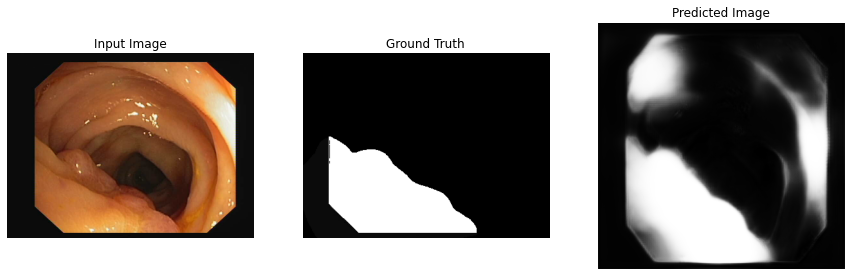

In [38]:
display(14)